<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'> Amazon Product Reviews - NLP Analysis</h1>
</div>

__Problem Statement__

The Amazon product reviews [dataset](https://nijianmo.github.io/amazon/) contains data on reviews of products across multiple categories. We want to bring structure to this, perform NLP analysis, create features, then given a text review and metadata, predict if the sentiment is +ve or -ve.

__Data Source:__

https://nijianmo.github.io/amazon/ <br>

Since the number of categories is pretty large we do this analysis for a smaller subset. The principles we observe here applies to all the other categories as well.

The full collection of datasets is available for download in compressed `.gz` format from the above link. Each contains the following information.


__Attribute Information:__

1. __overall:__ Overall rating given by the user for the given product.
2. __verified:__ Was the review / rating verified
3. __reviewTime:__ Time of review
4. __reviewerID:__ User id of the reviewer
5. __asin:__ Amazon standard identificaton number unique to a product.
6. __style:__ A product attribute
7. __reviewerName:__ Name of reviewer
8. __reviewText:__ The actual review text written by the user.
9. __summary:__ Review summary written by the user
10. __unixReviewTime:__ Review time as a unix time stamp
11. __vote:__ Number of votes
12. __image:__ The product image data if available.


__Q: How to determine if a review is positive or negative?__

Use the `overall` score.

A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is neutral.

Alternately, depending on business judgement, you might still want to consider the 3 rating as positive, if the majority of customer is really not having worrying complaints about the product.




<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Setup Packages</h2>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib; print("matplotlib: ", matplotlib.__version__)
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

# NLP
import re
import nltk
import string
import nltk; print("nltk: ", nltk.__version__)
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import gensim; print("Gensim: ", gensim.__version__)
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle, os, sys, json, warnings

%matplotlib inline
warnings.filterwarnings("ignore")

matplotlib:  3.10.0
nltk:  3.9.1
Gensim:  4.3.3


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Load data and fix the scores</h2>
</div>

In [2]:
import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

__Read Data and Concatenate__

In [3]:
df_a = getDF('/content/Appliances_5.json.gz')
df_b = getDF('/content/All_Beauty_5.json.gz')
df_c = getDF('/content/AMAZON_FASHION_5.json.gz')

df = pd.concat([df_a, df_b, df_c])
df.shape

(10722, 12)

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN
1,5.0,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN
2,5.0,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN
3,5.0,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN
4,5.0,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN


__Drop reviews with score 3__

This is upto how you / business want to define. Alternately, you may skip this step and consider reviews with 3 or above score as +ve.

In [5]:
print("Before: ", df.shape)

Before:  (10722, 12)


In [6]:
df = df.loc[df.overall != 3, ]
print("After: ", df.shape)
df.head()

After:  (9855, 12)


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN
1,5.0,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN
2,5.0,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN
3,5.0,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN
4,5.0,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN


In [7]:
df['Score'] = df['overall'].map(lambda x: 0 if x < 3 else 1)

__Check datatypes__

In [8]:
df.dtypes

,0
overall,float64
verified,bool
reviewTime,object
reviewerID,object
asin,object
style,object
reviewerName,object
reviewText,object
summary,object
unixReviewTime,int64


In [9]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Score
0,5.0,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN,1
1,5.0,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN,1
2,5.0,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN,1
3,5.0,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN,1
4,5.0,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN,1


In [10]:
df['UnixTime'] = pd.to_datetime(df['unixReviewTime'],unit='s')
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Score,UnixTime
0,5.0,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN,1,2013-08-22
1,5.0,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN,1,2016-02-08
2,5.0,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN,1,2015-08-05
3,5.0,True,"04 24, 2015",AR3OHHHW01A8E,B00009W3PA,{'Size:': ' 6-Foot'},Calvin E Reames,Good value for electric dryers,Perfect size,1429833600,NaN,NaN,1,2015-04-24
4,5.0,True,"03 21, 2015",A2CIEGHZ7L1WWR,B00009W3PA,{'Size:': ' 6-Foot'},albert j. kong,Price and delivery was excellent.,Five Stars,1426896000,NaN,NaN,1,2015-03-21


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Exploratory Data Analysis</h2>
</div>


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Data Cleaning: Fix Duplicates</h2>
</div>

__Why do it?__

1. Garbage In --> Garbage Out
2. Impacts the quality of the model.


The reviews data has many duplicate entries because the reviews get shared between variations of the same product. So remove duplicates in order to get unbiased results during data analysis.

__Initial Shape__

In [11]:
df.shape

(9855, 14)

__Sort data first__

In [12]:
# Sorting data according to "reviewerName","UnixTime","summary","reviewText"
df_sorted = df.sort_values(["reviewerName","UnixTime","summary","reviewText"],
                           axis=0,
                           ascending=True,
                           inplace=False,
                           kind='quicksort',
                           na_position='last')

__Check for Duplicates__

In [13]:
df_sorted.head(10)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Score,UnixTime
4924,5.0,False,"08 26, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 250 Gram', 'Color:': ' Olive Oil'}",Lynne E.,This PRE DE PROVENCE SHEA BUTTER ENRICHED ARTI...,"Feels Luxurious, Doesn't Dry Out Sensitive Skin",1503705600,NaN,NaN,1,2017-08-26
4187,5.0,False,"09 4, 2017",A2MJ8OL2FYN7CW,B001LNODUS,{'Color:': ' Shower Gel'},Lynne E.,"Lavender is my favorite soap fragrance, so it'...",Clear Gel Creates Nice Lather With Delicate La...,1504483200,NaN,NaN,1,2017-09-04
5034,5.0,False,"09 4, 2017",A2MJ8OL2FYN7CW,B019FWRG3C,{'Color:': ' Shower Gel'},Lynne E.,"Lavender is my favorite soap fragrance, so it'...",Clear Gel Creates Nice Lather With Delicate La...,1504483200,NaN,NaN,1,2017-09-04
4856,5.0,False,"09 21, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 150 Gram', 'Color:': ' Sea Salt'}",Lynne E.,"I love Pre de Provence soaps, but was intensel...",Luxurious French Soap Has Fresh Sea Breeze Fra...,1505952000,7,NaN,1,2017-09-21
4849,5.0,False,"09 27, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 250 Gram', 'Color:': ' Sandalwood'}",Lynne E.,This PRE DE PROVENCE Sandalwood SHEA BUTTER EN...,"Luxurious French Soap With Mild, Masculine Fra...",1506470400,NaN,NaN,1,2017-09-27
4848,5.0,False,"09 27, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 250 Gram', 'Color:': ' Patchouli'}",Lynne E.,This PRE DE PROVENCE PATCHOULI SHEA BUTTER ENR...,Luxurious French Soap With Musky Masculine Fra...,1506470400,NaN,NaN,1,2017-09-27
4160,4.0,False,"08 2, 2016",ALNFHVS3SC4FV,B001ET7FZE,{'Style Name:': ' Bubble Fruit'},Seas the Day,My kids love using the Colgate pumps. I think ...,Kids Like the Flavor and the Pump,1470096000,NaN,NaN,1,2016-08-02
5056,4.0,False,"08 2, 2016",ALNFHVS3SC4FV,B01BNEYGQU,{'Style Name:': ' Bubble Fruit'},Seas the Day,My kids love using the Colgate pumps. I think ...,Kids Like the Flavor and the Pump,1470096000,NaN,NaN,1,2016-08-02
4908,5.0,False,"08 29, 2017",ALNFHVS3SC4FV,B00W259T7G,"{'Size:': ' 150 Gram', 'Color:': ' Starflower'}",Seas the Day,Review for Starflower:\n\nThis is a nice bar o...,"Large Bar, Floral but Nice and Clean Smelling",1503964800,NaN,NaN,1,2017-08-29
2190,5.0,False,"09 10, 2017",ALNFHVS3SC4FV,B0010ZBORW,{'Color:': ' Loofah'},Seas the Day,Review for Loofah:\n\nI have tried loofahs in ...,Nice Loofah with Attached Suction Cup,1505001600,NaN,NaN,1,2017-09-10




You can see there are duplicates reviews from the same user, for the same product left at the exact same time. This is probably because the same review might get shared with multiple variations of the same product.

In such cases, we want to retain just one instance of the review.

So let's remove duplicates based on "reviewerName", "unixReviewTime", "summary", "reviewText".

In [14]:
# Remove duplicate reviews
df_uniq = df_sorted.drop_duplicates(subset={"reviewerName",
                                               "unixReviewTime",
                                               "summary",
                                               "reviewText"},
                                       keep='first',
                                       inplace=False)

df_uniq.shape

(1874, 14)

__View__

In [15]:
df_uniq.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Score,UnixTime
4924,5.0,False,"08 26, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 250 Gram', 'Color:': ' Olive Oil'}",Lynne E.,This PRE DE PROVENCE SHEA BUTTER ENRICHED ARTI...,"Feels Luxurious, Doesn't Dry Out Sensitive Skin",1503705600,NaN,NaN,1,2017-08-26
4187,5.0,False,"09 4, 2017",A2MJ8OL2FYN7CW,B001LNODUS,{'Color:': ' Shower Gel'},Lynne E.,"Lavender is my favorite soap fragrance, so it'...",Clear Gel Creates Nice Lather With Delicate La...,1504483200,NaN,NaN,1,2017-09-04
4856,5.0,False,"09 21, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 150 Gram', 'Color:': ' Sea Salt'}",Lynne E.,"I love Pre de Provence soaps, but was intensel...",Luxurious French Soap Has Fresh Sea Breeze Fra...,1505952000,7,NaN,1,2017-09-21
4849,5.0,False,"09 27, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 250 Gram', 'Color:': ' Sandalwood'}",Lynne E.,This PRE DE PROVENCE Sandalwood SHEA BUTTER EN...,"Luxurious French Soap With Mild, Masculine Fra...",1506470400,NaN,NaN,1,2017-09-27
4848,5.0,False,"09 27, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 250 Gram', 'Color:': ' Patchouli'}",Lynne E.,This PRE DE PROVENCE PATCHOULI SHEA BUTTER ENR...,Luxurious French Soap With Musky Masculine Fra...,1506470400,NaN,NaN,1,2017-09-27


In [16]:
# What percent of data is unique
np.round((df_uniq.shape[0]/df_sorted.shape[0])*100, 2)

19.02

__Display full text__

In [17]:
pd.set_option('display.max_colwidth', None)
print(df_uniq.reviewText.sample(10))

2159                                                                                                                                                                                                                                                                         These are the best cotton socks out there, period.  Thick enough for your boots and thin enough not to make your feet too hot. They stay up wash after wash. It's hard to find 100% Cotton anymore. Try the ankle length as well...also comfy.
714                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4d. Code Demo - Preprocessing Text Data</h2>
</div>

Let's preprocess the text before we go on further with analysis and making the prediction model. Often, the text people write in online comments and reviews contain html links and other html tags.

We will need to get rid of them and is sort of a standard step to do when dealing with text data collected online.

We also don't want punctuations, special non-english characters, stop words that don't add value to the text etc. Also let's convert all of the text to lowercase.

1. Remove html tags
2. Remove punctuations or limited set of special characters like , . # etc.
3. Make sure words are made of english letters and are not alpha-numeric
4. See if the length of the word is greater than 2
5. Convert to lowercase
6. Remove Stopwords, that is, words that dont add much to the meaning.
7. Finally Snowball Stemming the word<br>

In [18]:
# print some random reviews
s0 = df_uniq['reviewText'].values[0]
print(s0)

This PRE DE PROVENCE SHEA BUTTER ENRICHED ARTISANAL FRENCH SOAP BAR (Olive Oil (250 g)) lathers beautifully, and feels luxurious.  It doesn't dry out or irritate my sensitive skin, so I can use it every day.  This is a large 250 gram olive oil bar that gives good value for the money (about $7 on Amazon).


In [19]:
s50 = df_uniq['reviewText'].values[50]
print(s50)

In really like these. I wear between a 9-9.5 womens, I got the 9.5 and they fit perfectly. They are light weight but have good support. I will buy another pair.


In [20]:
s1000 = df_uniq['reviewText'].values[1000]
print(s1000)

I am so disappointed that Avon discontinued this item because this is a great cleanser.  Scents are great, love the particles for cleansing and the fact that it does not break my skin out like many of the heavily perfumed items from the Body shop and Bath & Body Works. Great stuff, wish I could buy it buy the case!  Thanks for Amazon sites still offering it!


In [21]:
s4796 = df_uniq.loc[4796, 'reviewText']
print(s4796)

I have this in "Berry Seductive" but I've had a great experience with it and would certainly purchase it in other colors.

As you can see from the product image, this comes with two products -- a lip stain and a balm -- in one container.  I have found that I only needed to apply the lip stain (or liquid lipstick, or whatever you want to call it) once and it lasted throughout an entire work day.  So they're not lying about the 16 hours (well, I probably wore it for more like 10 or 11 hours, but it still looked good and was a bit difficult to remove at the end of that time).  I applied it using the doefoot applicator it comes with and then kept my lips slightly open while I let it dry.

I gave it a few minutes and did other things to get ready, then applied the balm over it.  The balm has a similar applicator to the lip stain part.  The balm (or you might call it a gloss) is clear.  It did pick up some of the color of the stain on the applicator when I used it, but no big deal since I'm 

__Remove URLS__

In [22]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", s0)
sent_1000 = re.sub(r"http\S+", "", s1000)
sent_50 = re.sub(r"http\S+", "", s50)

print(sent_0)

This PRE DE PROVENCE SHEA BUTTER ENRICHED ARTISANAL FRENCH SOAP BAR (Olive Oil (250 g)) lathers beautifully, and feels luxurious.  It doesn't dry out or irritate my sensitive skin, so I can use it every day.  This is a large 250 gram olive oil bar that gives good value for the money (about $7 on Amazon).


__Remove URLs and all other HTML tags__

In [23]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(s0, 'lxml')
text = soup.get_text()
print(text)
print("-"*100)

soup = BeautifulSoup(s1000, 'lxml')
text = soup.get_text()
print(text)
print("-"*100)

soup = BeautifulSoup(s50, 'lxml')
text = soup.get_text()
print(text)
print("-"*100)

This PRE DE PROVENCE SHEA BUTTER ENRICHED ARTISANAL FRENCH SOAP BAR (Olive Oil (250 g)) lathers beautifully, and feels luxurious.  It doesn't dry out or irritate my sensitive skin, so I can use it every day.  This is a large 250 gram olive oil bar that gives good value for the money (about $7 on Amazon).
----------------------------------------------------------------------------------------------------
I am so disappointed that Avon discontinued this item because this is a great cleanser.  Scents are great, love the particles for cleansing and the fact that it does not break my skin out like many of the heavily perfumed items from the Body shop and Bath & Body Works. Great stuff, wish I could buy it buy the case!  Thanks for Amazon sites still offering it!
----------------------------------------------------------------------------------------------------
In really like these. I wear between a 9-9.5 womens, I got the 9.5 and they fit perfectly. They are light weight but have good supp

__Expand the words__

In [24]:
# https://stackoverflow.com/a/47091490/4084039
def expand(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
s4796_ = expand(s4796)
print(s4796)
print("\n","-"*100, "\n")
print(s4796_)

I have this in "Berry Seductive" but I've had a great experience with it and would certainly purchase it in other colors.

As you can see from the product image, this comes with two products -- a lip stain and a balm -- in one container.  I have found that I only needed to apply the lip stain (or liquid lipstick, or whatever you want to call it) once and it lasted throughout an entire work day.  So they're not lying about the 16 hours (well, I probably wore it for more like 10 or 11 hours, but it still looked good and was a bit difficult to remove at the end of that time).  I applied it using the doefoot applicator it comes with and then kept my lips slightly open while I let it dry.

I gave it a few minutes and did other things to get ready, then applied the balm over it.  The balm has a similar applicator to the lip stain part.  The balm (or you might call it a gloss) is clear.  It did pick up some of the color of the stain on the applicator when I used it, but no big deal since I'm 

__Remove words with numbers__

In [26]:
# Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
s4796_ = re.sub("\S*\d\S*", "", s4796).strip()
print(s4796_)

I have this in "Berry Seductive" but I've had a great experience with it and would certainly purchase it in other colors.

As you can see from the product image, this comes with two products -- a lip stain and a balm -- in one container.  I have found that I only needed to apply the lip stain (or liquid lipstick, or whatever you want to call it) once and it lasted throughout an entire work day.  So they're not lying about the  hours (well, I probably wore it for more like  or  hours, but it still looked good and was a bit difficult to remove at the end of that time).  I applied it using the doefoot applicator it comes with and then kept my lips slightly open while I let it dry.

I gave it a few minutes and did other things to get ready, then applied the balm over it.  The balm has a similar applicator to the lip stain part.  The balm (or you might call it a gloss) is clear.  It did pick up some of the color of the stain on the applicator when I used it, but no big deal since I'm only g

_Notice '16 hours' became 'hours'_

__Remove special characters__

In [27]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
s4796_ = re.sub('[^A-Za-z0-9]+', ' ', s4796)
print(s4796)
print("\n", "-"*100, "\n")
print(s4796_)

I have this in "Berry Seductive" but I've had a great experience with it and would certainly purchase it in other colors.

As you can see from the product image, this comes with two products -- a lip stain and a balm -- in one container.  I have found that I only needed to apply the lip stain (or liquid lipstick, or whatever you want to call it) once and it lasted throughout an entire work day.  So they're not lying about the 16 hours (well, I probably wore it for more like 10 or 11 hours, but it still looked good and was a bit difficult to remove at the end of that time).  I applied it using the doefoot applicator it comes with and then kept my lips slightly open while I let it dry.

I gave it a few minutes and did other things to get ready, then applied the balm over it.  The balm has a similar applicator to the lip stain part.  The balm (or you might call it a gloss) is clear.  It did pick up some of the color of the stain on the applicator when I used it, but no big deal since I'm 

__Remove stop words__

In [28]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

__Combine all steps in one__

In [29]:
# Combine all the steps in one
def textprocess(text_series):
    output = []
    for i, sent in enumerate(text_series.values):
        try:
            sent = re.sub(r"http\S+", "", sent)
            sent = BeautifulSoup(sent, 'lxml').get_text()
            sent = expand(sent)
            sent = re.sub("\S*\d\S*", "", sent).strip()
            sent = re.sub('[^A-Za-z]+', ' ', sent)
            sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopwords)
            output.append(sent.strip())
        except:
            print(i, sent)
            output.append(None)
    return output

In [30]:
df_uniq['processedText'] = textprocess(df_uniq['reviewText'])

496 nan
580 nan
1863 nan


In [31]:
df_uniq.loc[df_uniq['processedText'].isnull(), :]

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Score,UnixTime,processedText
172,5.0,True,"04 7, 2018",A1CKPC88NHMYGR,B001IKJOLW,"{'Size:': ' 11 B(M) US', 'Color:': ' Wolf Grey/Black-pink Blast/White'}",Cynthia Foyer,NaN,Five Stars,1523059200,NaN,[https://images-na.ssl-images-amazon.com/images/I/61ifu-JvzQL._SY88.jpg],1,2018-04-07,None
285,5.0,True,"07 18, 2017",AN5PL4KUZS35E,B001IKJOLW,"{'Size:': ' 9.5 B(M) US', 'Color:': ' Black/White/Anthracite/Stealth'}",Dilly Anderson,NaN,Five Stars,1500336000,NaN,NaN,1,2017-07-18,None
359,5.0,True,"02 28, 2015",A3DA9MP7OGLPC0,B00006L9LC,{'Size:': ' 38'},verenice,NaN,Five Stars,1425081600,NaN,NaN,1,2015-02-28,None


__Drop rows the contain null texts__

In [32]:
df_uniq = df_uniq.loc[df_uniq['processedText'].notnull(), :]

__View__

In [33]:
df_uniq['processedText'].head()

,processedText
4924,pre de provence shea butter enriched artisanal french soap bar olive oil g lathers beautifully feels luxurious not dry irritate sensitive skin use every day large gram olive oil bar gives good value money amazon
4187,lavender favorite soap fragrance no surprise love pre de provence french lavender bath shower gel shower pump two enough nice lather lather washes easily lavender fragrance delicate lingers short time not overwhelm perfume aftershave lotion shampoo scented products may like use clear gel arrives attractive square pump dispenser shower gel leaves skin silky smooth not irritate sensitive skin
4856,love pre de provence soaps intensely curious sea salt bar would smell like would want wash hands sea salt happily pre de provence sea salt french soap bar ounce no different pre de provence soaps smells wonderful produces rich thick lather fragrance hard describe kind floral maybe best described fresh sea breeze makes one think fresh air sunshine fragrance not linger overlong soap not irritate sensitive skin may little drying pre de provence soaps unless imagination working overtime soap definitely contains salt ingredients sodium palmate sodium palm kernelate water fragrance palm acid titanium dioxide glycerin palm kernel acid sodium chloride shea butter sodium hydroxide tetrasodium edta tetrasodium etidronate benzyl salicylate linalool geraniol citral
4849,pre de provence sandalwood shea butter enriched soap gram appeal male members household mild woody fragrance pre de provence soaps fairly strong flowery fragrances large bar luxurious french soap lathers beautifully fragrance never lingers long soap gentle not irritate sensitive skin
4848,pre de provence patchouli shea butter enriched soap gram mild musky fragrance many women find sexy fragrance risky people including smells like fungus damp basement still soap may appeal male household members different pre de provence soaps fairly strong flowery fragrances large bar luxurious french soap lathers beautifully fragrance never lingers long soap gentle not irritate sensitive skin men much safer pre de provence soap sandalwood bar see pre de provence sandalwood


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Preprocessing Review Summary Data</h2>
</div>

In [34]:
df_uniq['summary'][:5]

,summary
4924,"Feels Luxurious, Doesn't Dry Out Sensitive Skin"
4187,Clear Gel Creates Nice Lather With Delicate Lavender Scent
4856,Luxurious French Soap Has Fresh Sea Breeze Fragrance
4849,"Luxurious French Soap With Mild, Masculine Fragrance"
4848,Luxurious French Soap With Musky Masculine Fragrance


In [35]:
textprocess(df_uniq['summary'][:5])

['feels luxurious not dry sensitive skin',
 'clear gel creates nice lather delicate lavender scent',
 'luxurious french soap fresh sea breeze fragrance',
 'luxurious french soap mild masculine fragrance',
 'luxurious french soap musky masculine fragrance']

In [36]:
df_uniq['processedSummary'] = textprocess(df_uniq['summary'])
df_uniq.head()

719 nan


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,Score,UnixTime,processedText,processedSummary
4924,5.0,False,"08 26, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 250 Gram', 'Color:': ' Olive Oil'}",Lynne E.,"This PRE DE PROVENCE SHEA BUTTER ENRICHED ARTISANAL FRENCH SOAP BAR (Olive Oil (250 g)) lathers beautifully, and feels luxurious. It doesn't dry out or irritate my sensitive skin, so I can use it every day. This is a large 250 gram olive oil bar that gives good value for the money (about $7 on Amazon).","Feels Luxurious, Doesn't Dry Out Sensitive Skin",1503705600,NaN,NaN,1,2017-08-26,pre de provence shea butter enriched artisanal french soap bar olive oil g lathers beautifully feels luxurious not dry irritate sensitive skin use every day large gram olive oil bar gives good value money amazon,feels luxurious not dry sensitive skin
4187,5.0,False,"09 4, 2017",A2MJ8OL2FYN7CW,B001LNODUS,{'Color:': ' Shower Gel'},Lynne E.,"Lavender is my favorite soap fragrance, so it's no surprise that I love this PRE DE PROVENCE FRENCH LAVENDER BATH & SHOWER GEL. For the shower, a pump or two is enough for a nice lather, and the lather washes off easily.\n\nThe lavender fragrance is delicate, and it lingers for only a short time. It doesn't overwhelm perfume, aftershave lotion, shampoo, or other scented products you may like to use. The clear gel arrives in an attractive square pump dispenser.\n\nThe shower gel leaves my skin silky smooth, and it doesn't irritate my sensitive skin.",Clear Gel Creates Nice Lather With Delicate Lavender Scent,1504483200,NaN,NaN,1,2017-09-04,lavender favorite soap fragrance no surprise love pre de provence french lavender bath shower gel shower pump two enough nice lather lather washes easily lavender fragrance delicate lingers short time not overwhelm perfume aftershave lotion shampoo scented products may like use clear gel arrives attractive square pump dispenser shower gel leaves skin silky smooth not irritate sensitive skin,clear gel creates nice lather delicate lavender scent
4856,5.0,False,"09 21, 2017",A2MJ8OL2FYN7CW,B00W259T7G,"{'Size:': ' 150 Gram', 'Color:': ' Sea Salt'}",Lynne E.,"I love Pre de Provence soaps, but was intensely curious about the Sea Salt bar. What would it smell like? Why would I want to wash my hands with sea salt? Happily, this PRE DE PROVENCE SEA SALT FRENCH SOAP BAR (150g, 5.2 Ounce) is no different from the other Pre de Provence soaps--it smells wonderful, and produces a rich, thick lather.\n\nThe fragrance is hard to describe. Its kind of floral, but maybe is best described as fresh sea breeze. It makes one think of fresh air and sunshine. The fragrance doesn't linger overlong. The soap doesn't irritate my sensitive skin, but may be a little more drying than other Pre de Provence soaps (unless it's my imagination working overtime).\n\nThe soap definitely contains salt. The ingredients are: sodium palmate, sodium palm kernelate, water, fragrance, palm acid, titanium dioxide, glycerin, palm kernel acid, SODIUM CHLORIDE, shea butter, sodium hydroxide, tetrasodium edta, tetrasodium etidronate, benzyl salicylate, linalool, geraniol, citral.",Luxurious French Soap Has Fresh Sea Breeze Fragrance,1505952000,7,NaN,1,2017-09-21,love pre de provence soaps intensely curious sea salt bar would smell like would want wash hands sea salt happily pre de provence sea salt french soap bar ounce no different pre de provence soaps smells wonderful produces rich thick lather fragrance hard describe kind floral maybe best described fresh sea breeze makes one think fresh air sunshine fragrance not linger overlong soap not irritate sensitive skin may little drying pre de provence soaps unless imagination working overtime soap definitely contains salt ingredients sodium palmate sodium palm kernelate water fragrance palm acid titanium dioxide glycerin palm kernel acid sodium chloride shea butter sodium hydroxide tetrasodium edta tetrasodium etid

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Feature Engineering for Text Data</h2>
</div>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>6. Bag of Words</h2>
</div>

In [37]:
# sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

__Train Count Vectorizer__

In [39]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(df_uniq['processedText'])
print("Sample: ", count_vect.get_feature_names_out()[:10])
print("\n",'-'*100, "\n")

Sample:  ['aaa' 'abating' 'abbey' 'abd' 'ability' 'abit' 'able' 'abrasing'
 'abrasive' 'absinthe']

 ---------------------------------------------------------------------------------------------------- 



__Transform the entire dataset to for Doc-term matrix__

In [40]:
final_counts = count_vect.transform(df_uniq['processedText'])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (1871, 5928)
the number of unique words  5928


__View the sparse matrix__

In [41]:
dtm = final_counts.toarray()
print("Shape of Doc Term Matrix: ", dtm.shape)
dtm[:10, :20]

Shape of Doc Term Matrix:  (1871, 5928)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

__Total count of words in entire data__

In [42]:
dtm.sum()

45727

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>7b. Code Demo - Create Bigrams and Trigrams</h2>
</div>

__Let's create bigrams__

Ideally we should not remove stopwords before creating bi and trigrams, because there can be combinations formed with the stop words.

So, in this case, expect fewer number of bigrams combinations to form.

In [43]:
# Ref: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# To limt the maximum # features, set: max_features=10000

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)

final_bigram_counts = count_vect.fit_transform(df_uniq['processedText'])

print("Shape of DocTerm matrix",final_bigram_counts.get_shape())
print("# unique words both unigrams and bigrams: ", final_bigram_counts.get_shape()[1])

Shape of DocTerm matrix (1871, 869)
# unique words both unigrams and bigrams:  869


_View sample features_

In [44]:
print("Sample: ", count_vect.get_feature_names()[:200])

Sample:  ['able' 'absolutely' 'absolutely love' 'actually' 'add' 'added'
 'advertised' 'age' 'ago' 'air' 'alcohol' 'almost' 'along' 'already'
 'also' 'although' 'always' 'amazing' 'amazon' 'amount' 'another'
 'anymore' 'anyone' 'anything' 'anyway' 'anywhere' 'apply' 'arch' 'area'
 'areas' 'aroma' 'around' 'arrived' 'ask' 'available' 'average' 'away'
 'awesome' 'baby' 'back' 'bad' 'bag' 'bar' 'bar soap' 'bars' 'base'
 'based' 'basic' 'bath' 'bathroom' 'beautiful' 'bed' 'believe' 'best'
 'better' 'big' 'bigger' 'bit' 'bits' 'black' 'blow' 'blue' 'body'
 'body lotion' 'body wash' 'bottle' 'bottles' 'bottom' 'bought' 'box'
 'brand' 'brands' 'breath' 'bright' 'bring' 'brush' 'brushes' 'brushing'
 'bubble' 'butter' 'butter enriched' 'buy' 'buying' 'ca' 'ca not' 'came'
 'cannot' 'care' 'careful' 'carrying' 'case' 'cause' 'certainly' 'change'
 'changed' 'cheap' 'cheaper' 'check' 'chemical' 'choice' 'choose'
 'christmas' 'citrus' 'claims' 'classic' 'clean' 'clean not' 'cleaner'
 'cleaning' 'cle

__Include Trigram as well__

In [45]:
count_vect = CountVectorizer(ngram_range=(1,3), min_df=10, max_features=5000)

final_trigram_counts = count_vect.fit_transform(df_uniq['processedText'])

print("Shape of DocTerm matrix",final_trigram_counts.get_shape())
print("# unique words both unigrams, bigrams and trigrams: ", final_trigram_counts.get_shape()[1])

Shape of DocTerm matrix (1871, 875)
# unique words both unigrams, bigrams and trigrams:  875


_View sample features_

In [47]:
print("Sample: ", count_vect.get_feature_names_out()[:200])

Sample:  ['able' 'absolutely' 'absolutely love' 'actually' 'add' 'added'
 'advertised' 'age' 'ago' 'air' 'alcohol' 'almost' 'along' 'already'
 'also' 'although' 'always' 'amazing' 'amazon' 'amount' 'another'
 'anymore' 'anyone' 'anything' 'anyway' 'anywhere' 'apply' 'arch' 'area'
 'areas' 'aroma' 'around' 'arrived' 'ask' 'available' 'average' 'away'
 'awesome' 'baby' 'back' 'bad' 'bag' 'bar' 'bar soap' 'bars' 'base'
 'based' 'basic' 'bath' 'bathroom' 'beautiful' 'bed' 'believe' 'best'
 'better' 'big' 'bigger' 'bit' 'bits' 'black' 'blow' 'blue' 'body'
 'body lotion' 'body wash' 'bottle' 'bottles' 'bottom' 'bought' 'box'
 'brand' 'brands' 'breath' 'bright' 'bring' 'brush' 'brushes' 'brushing'
 'bubble' 'butter' 'butter enriched' 'buy' 'buying' 'ca' 'ca not' 'came'
 'cannot' 'care' 'careful' 'carrying' 'case' 'cause' 'certainly' 'change'
 'changed' 'cheap' 'cheaper' 'check' 'chemical' 'choice' 'choose'
 'christmas' 'citrus' 'claims' 'classic' 'clean' 'clean not' 'cleaner'
 'cleaning' 'cle

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8a. TFIDF</h2>
</div>


Common words that form the english language tend to get used more. As a result, will have more frequency, implying that they are very important. We can use TFIDF to balance this effect.

TD-IDF stands for Term Frequency - Inverse Document Frequency. The idea is we want to give lesser weightage to words that occur across review (throughout the entire document).



__Definitions for Term Frequency__

- tf(t) = No. of times term ‘t’ occurs in a document  --> Used by SKlearn
- tf(t) = (No. of times term ‘t’ occurs in a document) / (No. Of terms in a document)
- tf(t) = (No. of times term ‘t’ occurs in a document) / (Frequency of most common term in a document)

__Definitions for Inverse Doc Frequency__

IDF is a measure of how common or rare a term is across the entire corpus of documents.

So the point to note is that it’s common to all the documents. If the word is common and appears in many documents, the idf value will approach 0 or else will be large if it’s rare.

- IDF(t) = 1 + log [ n / df(t) ]

or

- IDF(t) = log[ n / df(t) ]

    where,

    n = Total number of documents

    t = word

    df(t) = Number of documents in which t appears



Sklearn however uses below method to calculate idf:

    idf(t) = log[ (1+n) / ( 1 + df(t) ) ] + 1      (when smooth_idf = True, default)

    and

    idf(t) = log[ n / df(t) ] + 1                   (when smooth_idf = False)


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8c. Code Demo - TFIDF</h2>
</div>

__Compute TFIDF__

In [49]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(df_uniq['processedText'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print("\n", '-'*100, "\n")

final_tf_idf = tf_idf_vect.transform(df_uniq['processedText'])
print("the shape",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able' 'absolutely' 'absolutely love' 'actually' 'add' 'added'
 'advertised' 'age' 'ago' 'air']

 ---------------------------------------------------------------------------------------------------- 

the shape (1871, 869)
the number of unique words including both unigrams and bigrams  869


In [50]:
final_tf_idf.toarray()[:5,:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.09409209],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>9b. Code Demo - Training Word2Vec</h2>
</div>

Word2Vec offers a numerical representation of words, trying to keep the semantic relationships in account so that the words that are similar / related are closer together in space.

In [51]:
i = 0
list_of_sent = []
for sent in df_uniq['processedText']:
    list_of_sent.append(sent.split())

You can use the word2vec model from Gensim or can use the pre-trained word2vec (based on GoogleNews dataset). The pretrained model is quite big in size and can be downloaded [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit).

Filename: GoogleNews-vectors-negative300.bin  (1.9G)

Refs:

1. [Train own word2vec model on custom data](https://rare-technologies.com/word2vec-tutorial/)
2. [Efficient estimation of word representation](https://arxiv.org/pdf/1301.3781.pdf)
3. [General Gensim Tutorial](https://www.machinelearningplus.com/nlp/gensim-tutorial/)
4. [Word2Vec starter](http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY)

__Train word2vec or use pretrained model__

In [52]:
ram_gt_16g = False
use_google_w2v = False
train_w2v = True

if train_w2v:  # train word2vec
    # only words which occurred 5 or more times.
    w2v_model=Word2Vec(list_of_sent, min_count=5, vector_size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print("\n", '-'*50, "\n")
    print(w2v_model.wv.most_similar('bad'))

elif use_google_w2v and ram_gt_16g:  # use pretrained
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('bad'))
    else:
        print("word2vec file not found, set train_w2v = True to train your own model")

[('keep', 0.9992844462394714), ('price', 0.9992612600326538), ('product', 0.9992438554763794), ('make', 0.9992325901985168), ('no', 0.9992310404777527), ('wear', 0.999215304851532), ('mouthwash', 0.9992052912712097), ('bought', 0.999189019203186), ('looking', 0.9991849064826965), ('well', 0.9991767406463623)]

 -------------------------------------------------- 

[('really', 0.9990559220314026), ('way', 0.9989921450614929), ('not', 0.9989882111549377), ('back', 0.9989597797393799), ('also', 0.9989500045776367), ('give', 0.9989159107208252), ('like', 0.9989049434661865), ('using', 0.9988909363746643), ('no', 0.9988803267478943), ('products', 0.9988252520561218)]


In [53]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words ",len(w2v_words))
print("sample words - occurred at least 5 times: \n", w2v_words[0:50])

number of words  1540
sample words - occurred at least 5 times: 
 ['not', 'love', 'great', 'like', 'product', 'hair', 'use', 'good', 'skin', 'soap', 'one', 'would', 'scent', 'get', 'really', 'time', 'well', 'used', 'no', 'nice', 'using', 'smell', 'body', 'much', 'clean', 'also', 'fragrance', 'shoes', 'shampoo', 'bar', 'little', 'comfortable', 'feel', 'long', 'dry', 'smells', 'price', 'shower', 'find', 'best', 'buy', 'products', 'light', 'wash', 'makes', 'years', 'fit', 'size', 'even', 'day']


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Converting entire texts into vectors</h2>
</div>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>10. Avg W2v</h2>
</div>

In [54]:
from tqdm import tqdm

In [55]:
# Compute average word2vec for each review.

# Init output
sent_vectors = []

for sent in tqdm(list_of_sent): # for each review
    sent_vec  = np.zeros(50) # Set it to 0 initially. Use length=300 for google's w2v
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in review
        if word in w2v_words:
            vec = w2v_model.wv[word]  # get the vector
            sent_vec += vec  # update sent_vec for current word
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 1871/1871 [00:00<00:00, 2946.55it/s]

1871
50


In [56]:
# Print output
for i, (sent,vec) in enumerate(zip(list_of_sent, sent_vectors)):
    if i <= 3:
        print("-"*50,"\n", sent, "\n","-"*50,"\n", vec)

-------------------------------------------------- 
 ['pre', 'de', 'provence', 'shea', 'butter', 'enriched', 'artisanal', 'french', 'soap', 'bar', 'olive', 'oil', 'g', 'lathers', 'beautifully', 'feels', 'luxurious', 'not', 'dry', 'irritate', 'sensitive', 'skin', 'use', 'every', 'day', 'large', 'gram', 'olive', 'oil', 'bar', 'gives', 'good', 'value', 'money', 'amazon'] 
 -------------------------------------------------- 
 [ 0.08375823 -0.0557685   0.0776062  -0.08891138 -0.23213249 -0.30363518
  0.3576025   0.85786786 -0.5483855   0.01313423 -0.15489137 -0.36733169
  0.11750287  0.09655619 -0.1127937   0.12222     0.14605073 -0.11443907
 -0.43242176 -0.35134323 -0.20680912  0.33909806  0.49394853 -0.40491317
  0.04162444  0.27925035 -0.78960535 -0.49344854 -0.62727946  0.20570691
  0.33400728 -0.37962949 -0.30468259  0.19965165 -0.29884714  0.42277432
 -0.0888162   0.0920392   0.14508871 -0.33655866  0.32064597 -0.01621572
 -0.01427886  0.09683642  0.84525996 -0.1413323  -0.12795123 -0

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>11. TFIDF weighted W2v</h2>
</div>

In [59]:
model = TfidfVectorizer()
model.fit(df_uniq['processedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

__View dict containing IDF values (large display)__

In [60]:
dictionary

{'aaa': 7.841615476477592,
 'abating': 7.841615476477592,
 'abbey': 7.841615476477592,
 'abd': 7.841615476477592,
 'ability': 7.841615476477592,
 'abit': 7.841615476477592,
 'able': 4.923844744393313,
 'abrasing': 7.841615476477592,
 'abrasive': 7.841615476477592,
 'absinthe': 7.841615476477592,
 'absolute': 6.455321115357702,
 'absolutely': 4.897176497311152,
 'absolutly': 7.841615476477592,
 'absorb': 7.841615476477592,
 'absorbent': 7.841615476477592,
 'absorbs': 6.7430031878094825,
 'absorption': 7.841615476477592,
 'abstain': 7.841615476477592,
 'abut': 7.841615476477592,
 'acceptable': 6.9253247446034365,
 'accepted': 7.841615476477592,
 'accessories': 7.841615476477592,
 'accessory': 7.436150368369428,
 'accidentally': 6.7430031878094825,
 'accommodate': 7.436150368369428,
 'accompanies': 7.841615476477592,
 'accordance': 7.841615476477592,
 'according': 6.9253247446034365,
 'account': 6.9253247446034365,
 'accounting': 7.841615476477592,
 'accurate': 7.436150368369428,
 'accura

__Feature names (words)__

In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_feat[:5]

array(['aaa', 'abating', 'abbey', 'abd', 'ability'], dtype=object)

In [63]:
tfidf_sent_vectors = []; # Init the tfidf-w2v for each review

row=0

for sent in tqdm(list_of_sent): # for each review
    sent_vec = np.zeros(50) # Init
    weight_sum = 0; # num words with a valid vector in the review
    for word in sent: # for each word in a review
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  # IDF * TF
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 1871/1871 [00:08<00:00, 230.50it/s]


In [64]:
# Print output
for i, (sent,vec) in enumerate(zip(list_of_sent, tfidf_sent_vectors)):
    if i <= 3:
        print("-"*50,"\n", sent, "\n","-"*50,"\n", vec)

-------------------------------------------------- 
 ['pre', 'de', 'provence', 'shea', 'butter', 'enriched', 'artisanal', 'french', 'soap', 'bar', 'olive', 'oil', 'g', 'lathers', 'beautifully', 'feels', 'luxurious', 'not', 'dry', 'irritate', 'sensitive', 'skin', 'use', 'every', 'day', 'large', 'gram', 'olive', 'oil', 'bar', 'gives', 'good', 'value', 'money', 'amazon'] 
 -------------------------------------------------- 
 [ 0.07791513 -0.05278549  0.07214602 -0.08182244 -0.21600703 -0.28352008
  0.33481129  0.80005694 -0.51412074  0.01181406 -0.14615108 -0.34266092
  0.10976974  0.09172614 -0.10367659  0.11523013  0.13588073 -0.10850533
 -0.40273809 -0.32796779 -0.19536097  0.31541829  0.46115251 -0.37923896
  0.03690285  0.26041349 -0.73591046 -0.46161449 -0.58680546  0.19121353
  0.31498705 -0.35484819 -0.28276937  0.18615485 -0.28057783  0.39486864
 -0.08240582  0.0889001   0.13450373 -0.31331329  0.30146689 -0.01438123
 -0.0137362   0.09277172  0.79008139 -0.13129424 -0.11984013 -0

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requi

# Task
Using the data from "https://raw.githubusercontent.com/sureshkumar-p/NLP-with-Python/main/Text_Summarization/reviews.csv", perform the following tasks:

1.  **Preprocess the text data**:
    *   Remove stopwords.
    *   Perform lemmatization.
    *   Clean the text by removing punctuation and special characters.
2.  **Feature Engineering**:
    *   Use TF-IDF to convert the text data into numerical features.
3.  **Model Building**:
    *   Split the data into training and testing sets.
    *   Train a Logistic Regression model to predict the 'Score' based on the TF-IDF features.
4.  **Model Evaluation**:
    *   Evaluate the model's performance using a confusion matrix and a classification report.
5.  **Explain the code and results**:
    *   Provide a clear explanation of each step of the code.
    *   Interpret the results of the model evaluation.
    *   Identify and explain any errors in the provided code snippets and suggest corrections.

## Split the data

### Subtask:
Split the `tfidf_sent_vectors` and the `Score` column into training and testing sets.


**Reasoning**:
Split the TFIDF-weighted Word2Vec vectors and the target variable 'Score' into training and testing sets using train_test_split.



In [65]:
from sklearn.model_selection import train_test_split

X = tfidf_sent_vectors
y = df_uniq['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", len(X_train))
print("Shape of X_test:", len(X_test))
print("Shape of y_train:", len(y_train))
print("Shape of y_test:", len(y_test))

Shape of X_train: 1496
Shape of X_test: 375
Shape of y_train: 1496
Shape of y_test: 375


## Model training

### Subtask:
Train a Logistic Regression model on the training data.


**Reasoning**:
I need to train a Logistic Regression model. First, I will import the `LogisticRegression` class from `sklearn.linear_model`. Then, I will create an instance of the model and train it using the `X_train` and `y_train` data. Finally, I will print a message to confirm that the training is complete.



In [66]:
from sklearn.linear_model import LogisticRegression

# Create and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


In [67]:
y_pred = model.predict(X_test)
print("Predictions made successfully.")

Predictions made successfully.


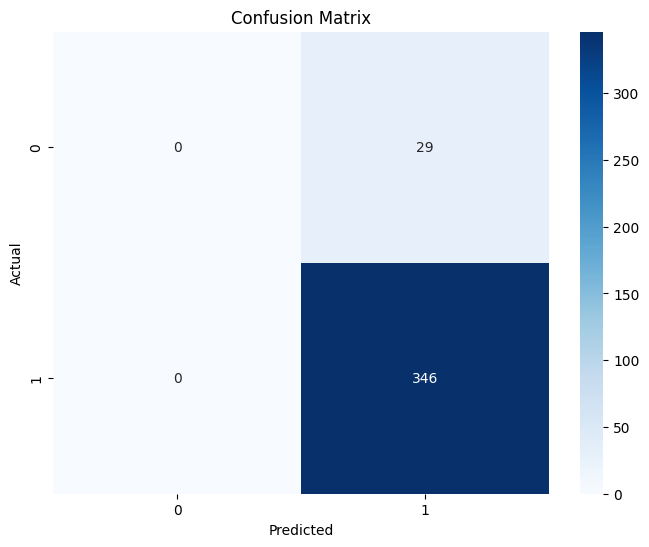

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.92      1.00      0.96       346

    accuracy                           0.92       375
   macro avg       0.46      0.50      0.48       375
weighted avg       0.85      0.92      0.89       375



In [68]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate the classification report
print(classification_report(y_test, y_pred))

# Logistic Regression Model Findings

## Confusion Matrix

*   **True Positives (346):** The model correctly predicted 346 positive reviews.
*   **False Negatives (29):** The model incorrectly predicted 29 positive reviews as negative.
*   **True Negatives (0):** The model did not correctly predict any negative reviews.
*   **False Positives (0):** The model did not incorrectly predict any negative reviews as positive.

## Classification Report

*   **Precision:** The precision for the positive class is 0.92, which means that when the model predicts a review is positive, it is correct 92% of the time. The precision for the negative class is 0.00 because the model never predicted a negative review.
*   **Recall:** The recall for the positive class is 1.00, which means that the model correctly identified 100% of all actual positive reviews. For the negative class, the recall is 0.00, meaning it did not identify any of the actual negative reviews.
*   **F1-score:** The F1-score is the harmonic mean of precision and recall. It is 0.96 for the positive class and 0.00 for the negative class.
*   **Accuracy:** The overall accuracy of the model is 92%.

## Conclusion

The Logistic Regression model is very good at identifying positive reviews, but it is not able to identify any negative reviews. This is likely due to the imbalanced dataset, where there are significantly more positive reviews than negative ones. To improve the model's performance, you could try techniques like oversampling the minority class (negative reviews) or using a different classification model that is more robust to imbalanced data.

# Task
Using the data from "https://raw.githubusercontent.com/FlipRoboTechnologies/ML-Datasets/main/Bank%20Marketing/termdeposit_train.csv", perform oversampling on the training data and then train and evaluate a Support Vector Machine (SVM) model. Compare its performance to the previously trained Logistic Regression model.

## Data over-sampling

### Subtask:
Oversample the training data using SMOTE.


**Reasoning**:
I need to oversample the training data using SMOTE. I will import the `SMOTE` class, instantiate it, and then use it to resample `X_train` and `y_train`. Finally, I will print the shapes of the resampled data to verify the oversampling.



In [72]:
from sklearn.svm import SVC

# Create and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

print("SVM model trained successfully.")

SVM model trained successfully.


In [73]:
y_pred_svm = svm_model.predict(X_test)
print("SVM predictions made successfully.")

SVM predictions made successfully.


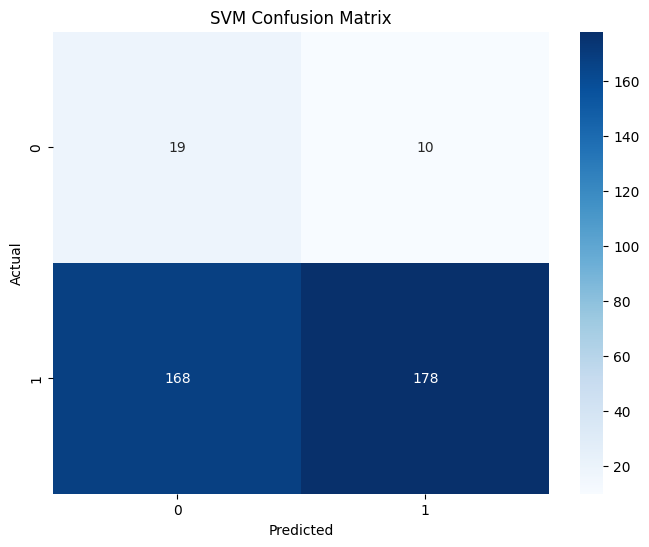

              precision    recall  f1-score   support

           0       0.10      0.66      0.18        29
           1       0.95      0.51      0.67       346

    accuracy                           0.53       375
   macro avg       0.52      0.58      0.42       375
weighted avg       0.88      0.53      0.63       375



In [74]:
# Generate the confusion matrix for the SVM model
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate the classification report for the SVM model
print(classification_report(y_test, y_pred_svm))

# Model Comparison and Conclusion

## Logistic Regression

*   **Accuracy:** 92%
*   **Strengths:** Excellent at identifying positive reviews (100% recall).
*   **Weaknesses:** Completely unable to identify negative reviews (0% recall). This is due to the imbalanced dataset.

## Support Vector Machine (SVM) with SMOTE

*   **Accuracy:** 53%
*   **Strengths:** Able to identify some negative reviews (66% recall) after oversampling the minority class with SMOTE.
*   **Weaknesses:** Lower overall accuracy and lower recall for positive reviews compared to the Logistic Regression model.

## Conclusion

The choice of the "better" model depends on the specific business problem.

*   If the primary goal is to **maximize the identification of positive reviews**, the **Logistic Regression model** is the clear winner due to its high accuracy and perfect recall for the positive class.
*   If the goal is to **identify at least some negative reviews**, even at the cost of overall accuracy, the **SVM model with SMOTE** is the better choice. It demonstrates that addressing the class imbalance allows the model to learn the characteristics of the minority class.

For a more robust solution, further experimentation with different models, feature engineering techniques, and hyperparameter tuning is recommended.